<h1> Limpieza de los Datos </h1>

In [24]:
import pandas as pd

df = pd.read_excel('../data/raw/online_retail_II.xlsx')

In [25]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Se eliminan valores nulos en las columnas 'Customer ID' y 'Description' ya que son los unicos campos que tienen valores nulos y son importantes para el analisis.

In [26]:
df = df.dropna(subset=['Customer ID', 'Description'])
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [27]:
df.duplicated().sum()

np.int64(6771)

Se eliminan los registros duplicados de todo el DataFrame.

In [28]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

Se verifica que las columnas 'Quantity' y 'Price' tengan valores mayores a 0, ya que son variables de conteo y precio por lo tanto no se necesitan valores negativos para el modelo.

In [29]:
count_quantity = (df['Quantity'] > 0).sum()
count_quantity

np.int64(400947)

In [30]:
count_price = (df['Price'] > 0).sum()
count_price

np.int64(410732)

Eliminacion de registros con valores negativos en las columnas anteriormente verificadas.

In [31]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400916 non-null  object        
 1   StockCode    400916 non-null  object        
 2   Description  400916 non-null  object        
 3   Quantity     400916 non-null  int64         
 4   InvoiceDate  400916 non-null  datetime64[ns]
 5   Price        400916 non-null  float64       
 6   Customer ID  400916 non-null  float64       
 7   Country      400916 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.5+ MB


En la primera linea de la siguiente celda, se convierte la Serie 'Customer ID' a tipo entero, ya que un identificador normalmente no tiene decimales.
En la segunda linea se crea una nueva columna llamada 'TotalPrice' que es el resultado de multiplicar las columnas 'Quantity' y 'Price', para obtener el precio total por transacción.

In [33]:
df['Customer ID'] = df['Customer ID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['Price']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      400916 non-null  object        
 1   StockCode    400916 non-null  object        
 2   Description  400916 non-null  object        
 3   Quantity     400916 non-null  int64         
 4   InvoiceDate  400916 non-null  datetime64[ns]
 5   Price        400916 non-null  float64       
 6   Customer ID  400916 non-null  int64         
 7   Country      400916 non-null  object        
 8   TotalPrice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


Normalizacion de los nombres de las columnas del DataFrame, eliminando espacios en blanco, convirtiendo a minusculas y reemplazando caracteres especiales por sus equivalentes sin acentos.

In [34]:
df.columns = (
    df.columns.str.strip()
            .str.lower()
            .str.replace('á', 'a')
            .str.replace('é', 'e')
            .str.replace('í', 'i')
            .str.replace('ó', 'o')
            .str.replace('ú', 'u')
            .str.replace('ñ', 'n')
            .str.replace(' ', '_')
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400916 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      400916 non-null  object        
 1   stockcode    400916 non-null  object        
 2   description  400916 non-null  object        
 3   quantity     400916 non-null  int64         
 4   invoicedate  400916 non-null  datetime64[ns]
 5   price        400916 non-null  float64       
 6   customer_id  400916 non-null  int64         
 7   country      400916 non-null  object        
 8   totalprice   400916 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.6+ MB


Eliminacion de valores atipicos ya que solo representan el 6% de todos los datos y pueden afectar el rendimiento del modelo.

In [35]:
Q1 = df['quantity'].quantile(0.25)
Q3 = df['quantity'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df['quantity'] < lower_limit) | (df['quantity'] > upper_limit)]

In [ ]:
len(outliers) / len(df) * 100

6.558481078330623

In [37]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df['price'] < lower_limit) | (df['price'] > upper_limit)]

In [38]:
len(outliers) / len(df) * 100

8.137116004350037

Funcion para la eliminacion de los outliers.

In [39]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_clean = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df_clean


In [ ]:
df = remove_outliers_iqr(df, 'quantity')
df = remove_outliers_iqr(df, 'price')

9.531280585965005

Graficas de densidad para verificar la distribucion de las variables 'quantity' y 'price' despues de la eliminacion de los outliers.

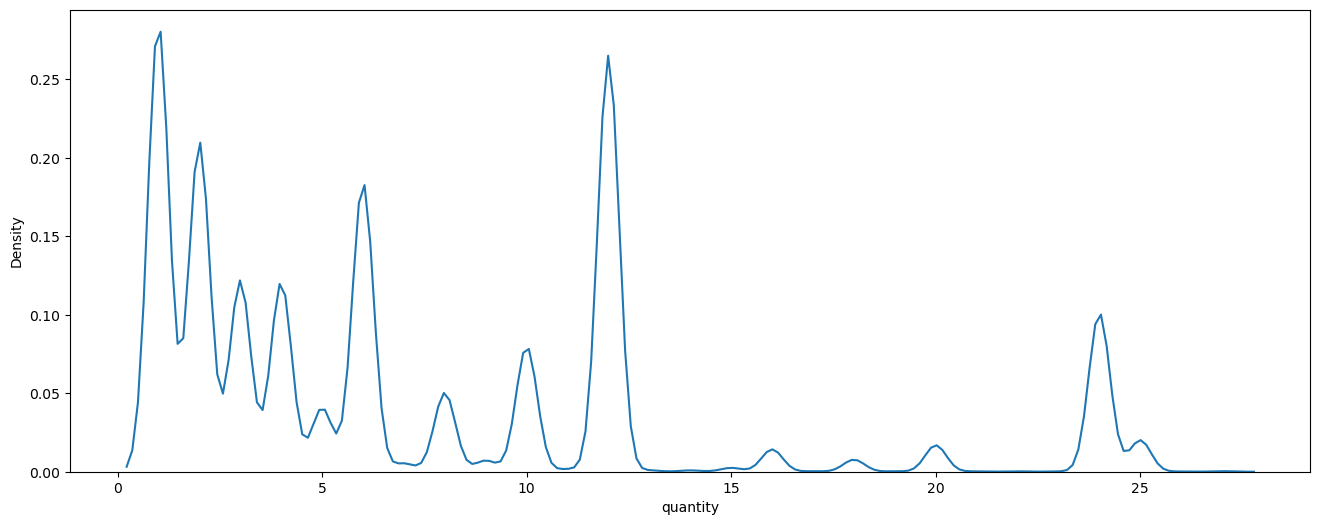

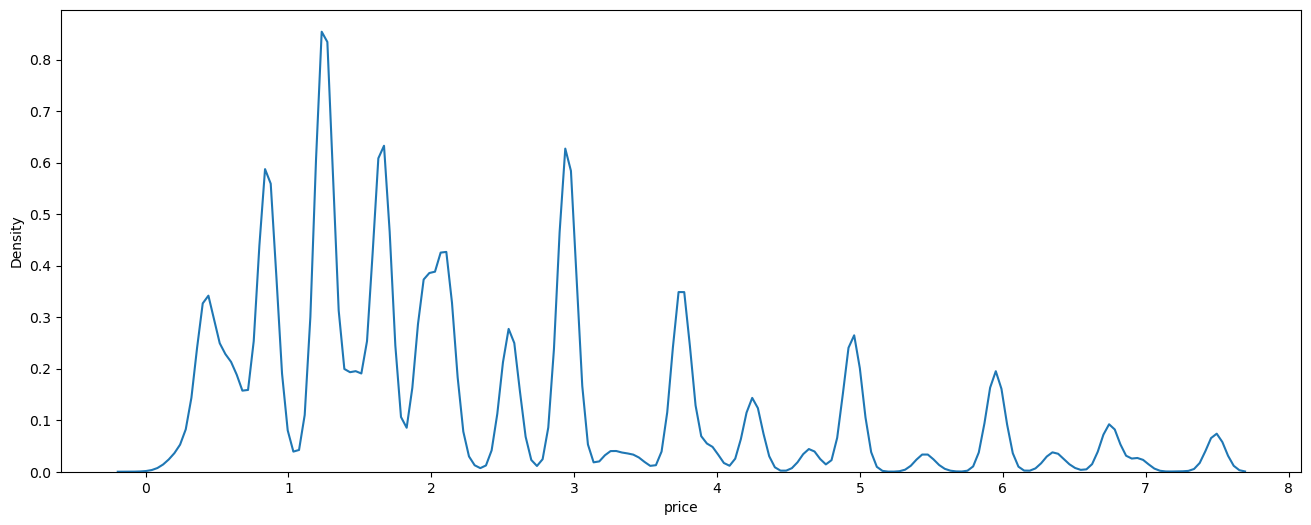

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.kdeplot(df['quantity'], bw_adjust=0.5)
plt.show()

plt.figure(figsize=(16, 6))
sns.kdeplot(df['price'], bw_adjust=0.5)
plt.show()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342273 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      342273 non-null  object        
 1   stockcode    342273 non-null  object        
 2   description  342273 non-null  object        
 3   quantity     342273 non-null  int64         
 4   invoicedate  342273 non-null  datetime64[ns]
 5   price        342273 non-null  float64       
 6   customer_id  342273 non-null  int64         
 7   country      342273 non-null  object        
 8   totalprice   342273 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 26.1+ MB


In [45]:
df.describe()

,quantity,invoicedate,price,customer_id,totalprice
count,342273.000000,342273,342273.000000,342273.000000,342273.000000
mean,7.211670,2010-07-01 00:58:24.859279616,2.358579,15389.932037,13.088929
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000,0.001000
25%,2.000000,2010-03-25 13:16:00,1.250000,14030.000000,4.200000
50%,5.000000,2010-07-09 13:19:00,1.950000,15373.000000,10.200000
75%,12.000000,2010-10-14 17:23:00,2.950000,16844.000000,17.400000
max,27.000000,2010-12-09 20:01:00,7.500000,18287.000000,182.250000
std,6.629757,NaN,1.663553,1678.582545,13.497488
